# MNIST Neural Network



## Loading Data

Load MNIST dataset, and split the training images into 80% images to use for training and 20% images to use for validation.  
(N.B. The images are greyscale values ranging from 0.0 to 255.0, so will later need rescaling from 0.0 to 1.0)

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

In [3]:
def preprocess(image, label):
    # Cast to float32, normalise, and reshape to (28, 28, 1)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, (28, 28, 1))
    return image, label

batch_size = 10

# Load datasets
train_digits = tfds.load('mnist', split='train[:80%]', shuffle_files=True, as_supervised=True)
val_digits   = tfds.load('mnist', split='train[80%:]', as_supervised=True)
test_digits  = tfds.load('mnist', split='test', as_supervised=True)

# Apply preprocessing and batching
train_digits = train_digits.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_digits   = val_digits.map(preprocess).batch(batch_size)
test_digits  = test_digits.map(preprocess).batch(batch_size)

## Create CNN

Create Convolutional Neural Network model to train on MNIST data.

In [25]:
input_shape = (28, 28, 1)
input = tf.keras.Input(shape=(28, 28, 1))
regularizer = tf.keras.regularizers.L2(0.005)

# Conv2d layer, with 20 5x5 filter and stride 1
Z1 = tf.keras.layers.Conv2D(20, (5, 5), strides=1, activity_regularizer=regularizer)(input)
# ReLU
A1 = tf.keras.layers.ReLU()(Z1)
# Max Pooling window 2x2, stride 2
P1 = tf.keras.layers.MaxPool2D((2,2), (2,2))(A1)
# Cov2d layer, with 40 5x5 filters and stride 2
Z2 = tf.keras.layers.Conv2D(40, (5, 5), strides=1, activity_regularizer=regularizer)(P1)
# ReLU
A2 = tf.keras.layers.ReLU()(Z2)
# Max pooling window 2x2, stride 2
P2 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(A2)
# Flatten
F = tf.keras.layers.Flatten()(P2)
FD = tf.keras.layers.Dropout(0.4)(F)
# dense layer, 80 nodes
D1 = tf.keras.layers.Dense(80, activation='relu', activity_regularizer=regularizer)(FD)
D1D = tf.keras.layers.Dropout(0.4)(D1)
# output layer
output = tf.keras.layers.Dense(10, activation='softmax')(D1D)

model = tf.keras.Model(inputs=input, outputs=output)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 20)     │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 24, 24, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 12, 12, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 40)       │        20,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 80)             │        51,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,650 (283.79 KB)

 Trainable params: 72,650 (283.79 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

Train the model on the training data, and use validation data to track accuracy and progress

In [26]:
history = model.fit(train_digits, epochs=20, validation_data=val_digits)

Epoch 1/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 85s 17ms/step - accuracy: 0.8800 - loss: 0.8063 - val_accuracy: 0.9651 - val_loss: 0.3442
Epoch 2/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.9495 - loss: 0.4019 - val_accuracy: 0.9735 - val_loss: 0.2767
Epoch 3/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9530 - loss: 0.3585 - val_accuracy: 0.9772 - val_loss: 0.2682
Epoch 4/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.9548 - loss: 0.3492 - val_accuracy: 0.9794 - val_loss: 0.2440
Epoch 5/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.9559 - loss: 0.3385 - val_accuracy: 0.9775 - val_loss: 0.2981
Epoch 6/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9565 - loss: 0.3398 - val_accuracy: 0.9825 - val_loss: 0.2366
Epoch 7/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9572 - loss: 0.3383 - val_accuracy: 0.9796 - val_loss: 0.2253
Epoch 8/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - accuracy: 0.9563 - loss: 

### View Training History

C:\Users\User\AppData\Local\Temp\ipykernel_14484\1989446866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss': 'Training', 'val_loss': 'Validation'}, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_14484\1989446866.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy': 'Training', 'val_accuracy': 'Validation'}, inplace=True)


<Axes: title={'center': 'Model Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>

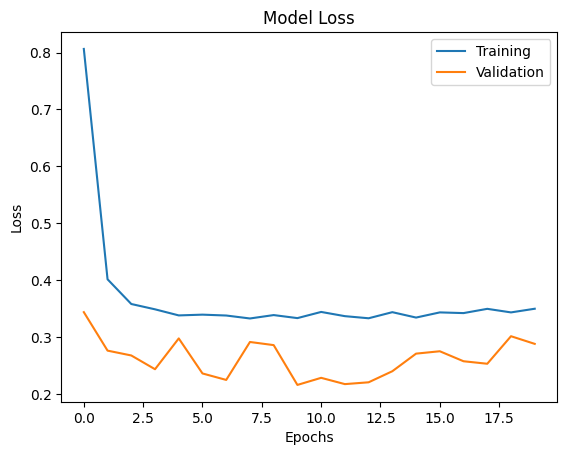

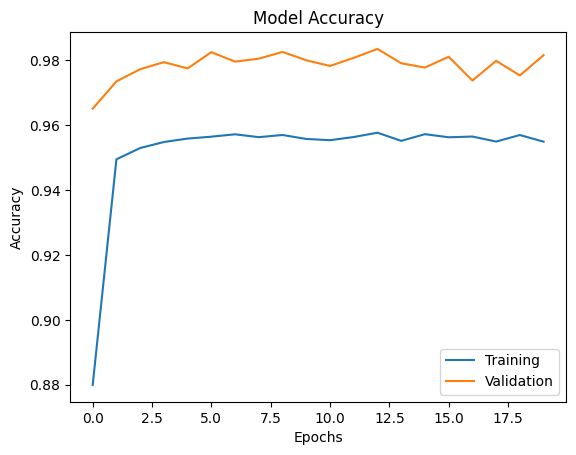

In [27]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[['loss', 'val_loss']]
df_loss.rename(columns={'loss': 'Training', 'val_loss': 'Validation'}, inplace=True)

df_acc = df_loss_acc[['accuracy', 'val_accuracy']]
df_acc.rename(columns={'accuracy': 'Training', 'val_accuracy': 'Validation'}, inplace=True)

df_loss.plot(title='Model Loss', ylabel='Loss', xlabel='Epochs')
df_acc.plot(title='Model Accuracy', ylabel='Accuracy', xlabel='Epochs')

# Test Model

Test the model on test data.

In [28]:
#model.evaluate(test_digits)
model.save('mnist_conv_regularized_dropout_98.00.keras')